In [24]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64
from matplotlib import rcParams

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

rcParams['font.family'] = 'arial'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 2


In [5]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [6]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [7]:
df_metabolites_reversed = df_metabolites.reset_index().set_index('newID')
df_microbes_reversed = df_microbes.reset_index().set_index('newID')
MAX_ID_metabolites = len(df_metabolites)
MAX_ID_microbes = len(df_microbes)

In [8]:
## Corrections for metabolite and microbial IDs when there is an error happens to them
'''
for i in range(0, 100):
    for j in range(len(df[i])):
        max_links = MAX_ID_metabolites * MAX_ID_microbes
        pos_x = df[i]['position in x'].iloc[j]
        edgeType = 2 + int(pos_x >= max_links)
        pos_x = pos_x - (edgeType - 2) * max_links
        row = pos_x // NumMicrobes
        col = pos_x - row * NumMicrobes

        metID = df_metabolites_reversed.loc[row].values[0]
        microbeID = df_microbes_reversed.loc[col].values[0]
        metName = names.loc[metID].values[0]
        microbeName = names.loc[microbeID].values[0]

        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]
        
for i in range(1, 101):
    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')
    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')
    
'''

"\nfor i in range(0, 100):\n    for j in range(len(df[i])):\n        max_links = MAX_ID_metabolites * MAX_ID_microbes\n        pos_x = df[i]['position in x'].iloc[j]\n        edgeType = 2 + int(pos_x >= max_links)\n        pos_x = pos_x - (edgeType - 2) * max_links\n        row = pos_x // NumMicrobes\n        col = pos_x - row * NumMicrobes\n\n        metID = df_metabolites_reversed.loc[row].values[0]\n        microbeID = df_microbes_reversed.loc[col].values[0]\n        metName = names.loc[metID].values[0]\n        microbeName = names.loc[microbeID].values[0]\n\n        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]\n        \nfor i in range(1, 101):\n    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')\n    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')\n    \n"

In [9]:
df_allhyperparameter = []
hyperparamter_list1 = ["1e-4","1e-3","3e-3","1e-2"] #["1e-4","1e-3","3e-3","1e-2","1e-1"]
hyperparamter_list2 = ["1e-4","1e-3","3e-3","1e-2","1e-1"]
for hyperparameter_numLinks in hyperparamter_list1:
    for hyperparameter_rewards in hyperparamter_list2:
        df_subset = []
        for i in range(1, 51):
            df_subset.append(pd.read_csv('./data/campusCluster/added_links_prior_distribution_hyperNumLinks'+hyperparameter_numLinks+'_hyperRewards'+hyperparameter_rewards+'_run'+str(i)+'.csv', index_col=0))
        df_allhyperparameter.append(df_subset)

In [10]:
df2_allhyperparameter = []
hyperparamter_list1 = ["1e-4","1e-3","3e-3","1e-2"] #["1e-4","1e-3","3e-3","1e-2","1e-1"]
hyperparamter_list2 = ["1e-4","1e-3","3e-3","1e-2","1e-1"]
for hyperparameter_numLinks in hyperparamter_list1:
    for hyperparameter_rewards in hyperparamter_list2:
        df2_subset = []
        for i in range(1, 51):
            df2_subset.append(pd.read_csv('./data/campusCluster/train_test_prior_distribution_hyperNumLinks'+hyperparameter_numLinks+'_hyperRewards'+hyperparameter_rewards+'_run'+str(i)+'.csv', index_col=0))
        df2_allhyperparameter.append(df2_subset)

In [11]:
df_allError = []
for hyperparameter_numLinks in hyperparamter_list1:
    for hyperparameter_rewards in hyperparamter_list2:
        df_error = []
        for i in range(1, 51):
            df_error.append(pd.read_csv('./data/campusCluster/train_test_prior_distribution_hyperNumLinks'+hyperparameter_numLinks+'_hyperRewards'+hyperparameter_rewards+'_run'+str(i)+'.csv', index_col=0))
        df_allError.append(df_error)

In [12]:
error_summary = np.zeros((len(hyperparamter_list1), len(hyperparamter_list2), 2, 3))
for i in range(len(df_allError)):
    df_error = []
    error = np.zeros((50, 2, 3))
    for j in range(0, 50):
        error[j,:,:] = df_allError[i][j].values
    row = i // len(hyperparamter_list2)
    col = i - row * len(hyperparamter_list2)
    error_summary[row,col,:,:] = np.median(error, 0)

## Varying the hyperparameter for number of links and fixed the hyperparameter for rewarding more metabolites as $10^{-3}$

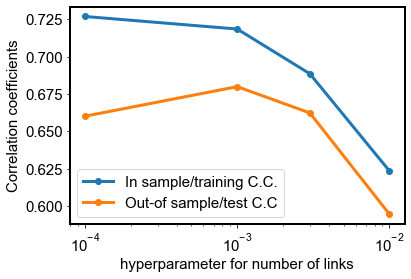

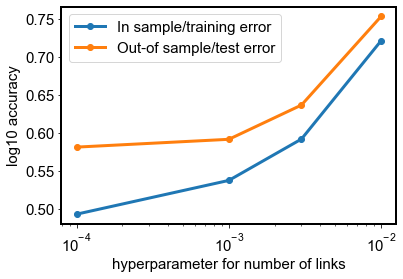

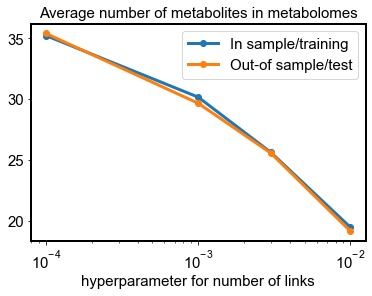

In [28]:
hyperparamter_list1_numeric = list(map(lambda x: float(x), hyperparamter_list1))
i_hyper = 1

plt.figure()
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 0, 0],'o-',linewidth=3,label='In sample/training C.C.')
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 1, 0],'o-',linewidth=3, label='Out-of sample/test C.C')
plt.xscale('log')
plt.xlabel('hyperparameter for number of links')
plt.ylabel('Correlation coefficients')
plt.legend();
plt.savefig('./figures/fig2C.svg')

plt.figure()
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 0, 1],'o-',linewidth=3, label='In sample/training error')
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 1, 1],'o-',linewidth=3, label='Out-of sample/test error')
plt.xscale('log')
plt.xlabel('hyperparameter for number of links')
plt.ylabel('log10 accuracy') 
plt.legend();
#plt.savefig('./figures/fig2C.svg')

plt.figure()
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 0, 2],'o-',linewidth=3, label='In sample/training')
plt.plot(hyperparamter_list1_numeric, error_summary[:, i_hyper, 1, 2],'o-',linewidth=3, label='Out-of sample/test')
plt.xscale('log')
plt.xlabel('hyperparameter for number of links')
plt.title('Average number of metabolites in metabolomes')
plt.legend();
#plt.savefig('./figures/fig2D.svg')


## Varying the hyperparameter for rewarding more metabolites and fixed the hyperparameter for number of links as $10^{-3}$

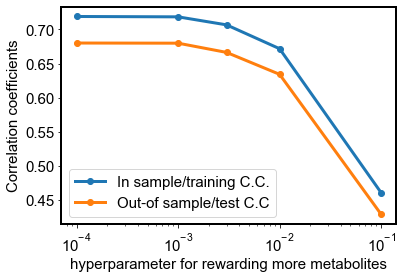

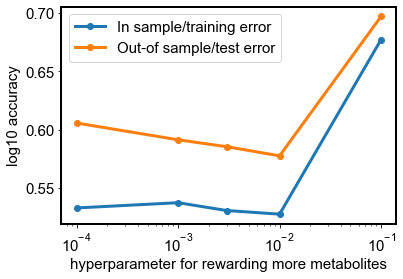

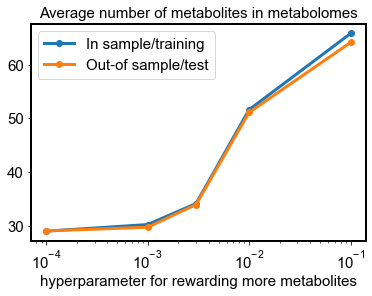

In [27]:
hyperparamter_list2_numeric = list(map(lambda x: float(x), hyperparamter_list2))
i_hyper = 1

plt.figure()
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 0, 0], 'o-', linewidth=3, label='In sample/training C.C.')
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 1, 0],'o-',linewidth=3, label='Out-of sample/test C.C')
plt.xscale('log')
plt.xlabel('hyperparameter for rewarding more metabolites')
plt.ylabel('Correlation coefficients')
plt.legend();
plt.savefig('./figures/fig2D.svg')

plt.figure()
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 0, 1],'o-',linewidth=3, label='In sample/training error')
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 1, 1],'o-',linewidth=3, label='Out-of sample/test error')
plt.xscale('log')
plt.xlabel('hyperparameter for rewarding more metabolites')
plt.ylabel('log10 accuracy') 
plt.legend();
#plt.savefig('./figures/fig2G.svg')

plt.figure()
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 0, 2],'o-',linewidth=3, label='In sample/training')
plt.plot(hyperparamter_list2_numeric, error_summary[i_hyper, :, 1, 2],'o-',linewidth=3, label='Out-of sample/test')
plt.xscale('log')
plt.xlabel('hyperparameter for rewarding more metabolites')
plt.title('Average number of metabolites in metabolomes')
plt.legend();
#plt.savefig('./figures/fig2H.svg')

## Pcolor plots for varying both hyperparameters

Text(0, 0.5, 'hyperparameter for \n number of links')

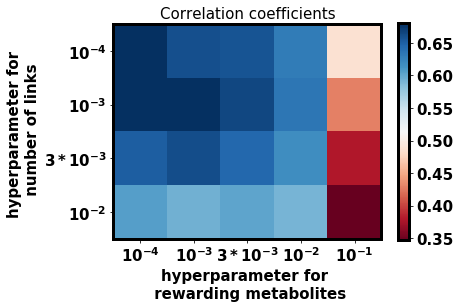

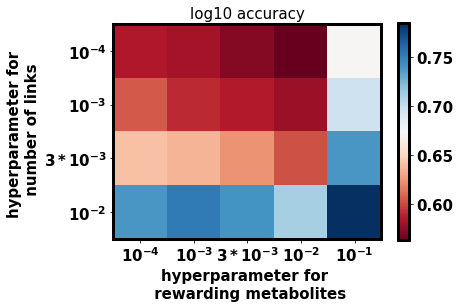

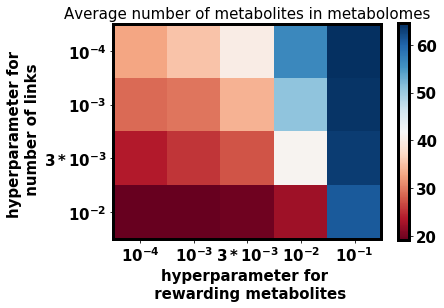

In [12]:
hyperparamter_list1_latex = ["$10^{-4}$", "$10^{-3}$", "$3 * 10^{-3}$", "$10^{-2}$"]
hyperparamter_list2_latex = ["$10^{-4}$", "$10^{-3}$", "$3*10^{-3}$", "$10^{-2}$", "$10^{-1}$"]

plt.figure()
plt.imshow(error_summary[:, :, 1, 0], cmap='RdBu')
plt.colorbar()
plt.title('Correlation coefficients')
plt.yticks(range(len(hyperparamter_list1_numeric)), hyperparamter_list1_latex);
plt.xticks(range(len(hyperparamter_list2_numeric)), hyperparamter_list2_latex);
plt.xlabel("hyperparameter for \n rewarding metabolites")
plt.ylabel("hyperparameter for \n number of links")

plt.figure()
plt.imshow(error_summary[:, :, 1, 1], cmap='RdBu')
plt.colorbar()
plt.title('log10 accuracy')
plt.yticks(range(len(hyperparamter_list1_numeric)), hyperparamter_list1_latex);
plt.xticks(range(len(hyperparamter_list2_numeric)), hyperparamter_list2_latex);
plt.xlabel("hyperparameter for \n rewarding metabolites")
plt.ylabel("hyperparameter for \n number of links")

plt.figure()
plt.imshow(error_summary[:, :, 1, 2], cmap='RdBu')
plt.colorbar()
plt.title('Average number of metabolites in metabolomes')
plt.yticks(range(len(hyperparamter_list1_numeric)), hyperparamter_list1_latex);
plt.xticks(range(len(hyperparamter_list2_numeric)), hyperparamter_list2_latex);
plt.xlabel("hyperparameter for \n rewarding metabolites")
plt.ylabel("hyperparameter for \n number of links")

In [101]:
error_summary[:, :, 1, 2]

array([[32.81818182, 35.40909091, 40.18181818, 56.5       , 64.59090909],
       [29.        , 29.68181818, 33.90909091, 51.09090909, 64.13636364],
       [23.90909091, 25.59090909, 27.5       , 41.27272727, 63.5       ],
       [19.13636364, 19.18181818, 19.68181818, 22.59090909, 61.        ]])

In [8]:
df_all = df[0].copy()
for i in range(1, len(df)):
    df_all = pd.concat([df_all, df[i]])
#df_all.set_index('position in x', inplace=True)
df_all.sort_values(['metabolite ID', 'microbes ID'])

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
66,2002,"1,2-diacylglycerol (1-acylglycerol, Monoacylgl...",812,Parabacteroides distasonis,3,-0.001000,756,16036
90,2002,"1,2-diacylglycerol (1-acylglycerol, Monoacylgl...",870,Prevotella copri,3,-0.000557,1242,16039
54,2003,"1,2-Ethanediol (Ethylene glycol)",119,Bacteroides caccae,2,-0.000504,394,150
22,2003,"1,2-Ethanediol (Ethylene glycol)",157,Bifidobacterium longum (Bifidobacterium infant...,2,-0.000296,135,167
13,2003,"1,2-Ethanediol (Ethylene glycol)",401,Desulfovibrio piger,3,0.000087,55,16091
65,2003,"1,2-Ethanediol (Ethylene glycol)",880,Prevotella timonensis,2,0.000120,507,201
11,2005,"1,3-Propanediol",161,Blautia hansenii (Ruminococcus hansenii),3,0.001069,67,16226
60,2005,"1,3-Propanediol",965,Ruminococcus flavefaciens,3,-0.000921,556,16262
14,2006,2-Aminobutyric acid (2-Aminobutyrate),55,Alistipes shahii,3,0.006803,69,16275
82,2006,2-Aminobutyric acid (2-Aminobutyrate),309,Clostridium difficile,3,0.000023,956,16300


In [9]:
links_added = []
for i in range(len(df)):
    links_added.append(set(df[i]['position in x'].values))

101.83 12.966152089189762


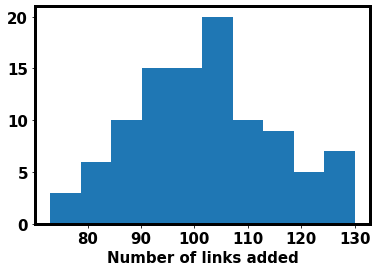

In [10]:
numLinksAdded = list(map(len, links_added))
plt.figure()
plt.hist(numLinksAdded);
plt.xlabel('Number of links added')
print(np.mean(numLinksAdded), np.std(numLinksAdded))

In [11]:
#set.union(links_added[0], links_added[1])

#list(links_added[0]) + list(links_added[1])

from collections import Counter, OrderedDict
#Counter(links_added)

import functools 
prevOfLinks = Counter(functools.reduce(lambda a,b : list(a)+list(b), links_added))

In [12]:
#prevOfLinks.items()
from collections import OrderedDict
# prevOfLinksSorted = {k: v for k, v in OrderedDict(sorted(prevOfLinks.items(), key=lambda item: item[1], reverse=True)}
prevOfLinksSorted = OrderedDict(OrderedDict(sorted(prevOfLinks.items(), key=lambda item: item[1], reverse=True)))

#np.argsort(prevOfLinksSorted.values)

Text(0, 0.5, 'prevalence of added link')

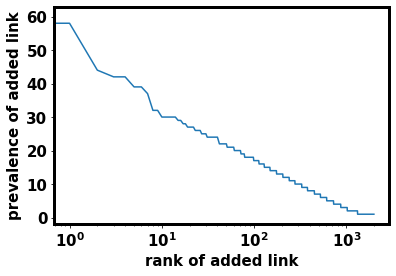

In [13]:
plt.plot(list(range(len(prevOfLinksSorted))), list(prevOfLinksSorted.values()))
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('rank of added link')
plt.ylabel('prevalence of added link')

Number of significant links and total links is:
724 1982
0.36528758829465185


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


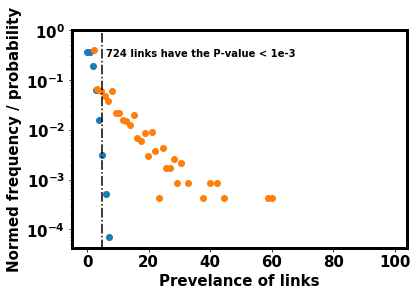

In [22]:
from scipy.stats import bernoulli, binom
NUMSIM = len(df)
xx = range(NUMSIM)
p = np.mean(numLinksAdded) / 10000
probCum = binom.cdf(xx, NUMSIM, p)
prob = binom.pmf(xx, NUMSIM, p)
threshold = np.where(probCum > 1 - 1e-3)[0][0]

numOfSigLinks = np.sum(np.array(list(prevOfLinksSorted.values())) >= threshold)
numOfTotalLinks = np.array(list(prevOfLinksSorted.values())).shape[0]
print('Number of significant links and total links is:')
print(numOfSigLinks, numOfTotalLinks)
print(numOfSigLinks / numOfTotalLinks)

ys_actual, xs_actual = np.histogram(list(prevOfLinksSorted.values()), bins=5, normed=True)

plt.plot(xx, prob, 'o')
ys_actual, xs_actual = np.histogram(list(prevOfLinksSorted.values()), bins=50, normed=True)
plt.plot(xs_actual[1:(1+NUMSIM)], ys_actual, 'o')
plt.plot([threshold, threshold], [0, 1], 'k-.')
plt.yscale('log'); plt.ylim([np.min(ys_actual[ys_actual > 1e-10])/10, 1])
plt.xlabel('Prevelance of links')
plt.ylabel('Normed frequency / probability')
plt.text(threshold+1, 0.3, str(numOfSigLinks)+' links have the P-value < 1e-3');
#plt.text(threshold+1, 0.5, 'P-value < 1e-3')

## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4350254292045665
            Iterations: 10
            Function evaluations: 227
            Gradient evaluations: 10
     fun: 2.4350254292045665
     jac: array([ 0.        , -0.00853819,  0.07028782,  0.00888675,  0.5158169 ,
        0.00695616,  0.5158169 , -0.00318575,  0.23650047, -0.00714117,
        0.23884735,  0.1009917 ,  0.07105842, -0.00713146, -0.00863993,
        0.09273681,  0.5424481 ,  0.61806461, -0.01410729, -0.00784275])
 message: 'Optimization terminated successfully.'
    nfev: 227
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([5.00000000e-02, 1.18522175e+00, 6.05657813e-15, 5.55845978e-02,
       5.76567800e-15, 7.84340336e-01, 5.83405308e-15, 1.46314133e-02,
       4.17078655e-15, 1.16066460e+00, 5.15701444e-15, 6.37199005e-15,
       5.19076232e-15, 1.15865506e+00, 1.17948029e+00, 5.46294989e-15,
       6.60426658e-15, 5.89703126e-15, 1.27764841

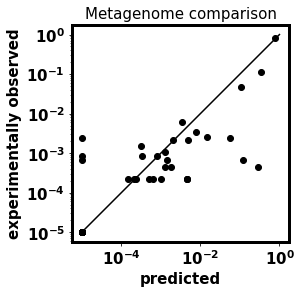

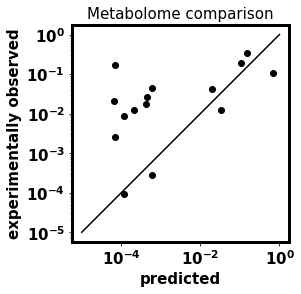

In [6]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 1; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


In [24]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
for netNUM in range(len(df)):
    #netNUM = 0
    net_added = df[netNUM].iloc[:, np.array([0,2,4])]
    net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
    net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
    net_added.columns = net.columns

    net_new = pd.concat([net_ori, net_added])

    corr_list = np.zeros((41,2))
    diet_list = np.zeros((41, 20))
    log_list = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net_new)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
        log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        diet_list[pa, :] = res.x
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''
    '''
    print('Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:')
    print(np.mean(corr_list[:,1]))
    print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
    print(np.mean(log_list[:,1]))
    '''
    corr_allreplicates.append(np.mean(corr_list[:,1]))
    log10_allreplicates.append(np.mean(log_list[:,1]))


/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Text(0, 0.5, 'log10 accuracy')

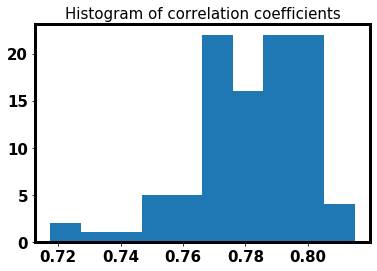

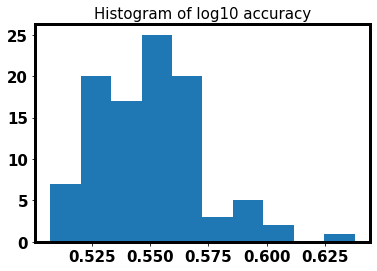

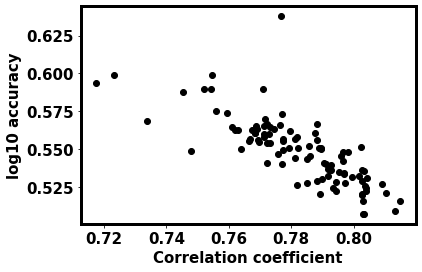

In [25]:
plt.figure()
plt.hist(corr_allreplicates)
plt.title('Histogram of correlation coefficients')

plt.figure()
plt.hist(log10_allreplicates)
plt.title('Histogram of log10 accuracy')

plt.figure()
plt.plot(corr_allreplicates, log10_allreplicates, 'ko')
plt.xlabel('Correlation coefficient')
plt.ylabel('log10 accuracy')

In [26]:
pearsonr(corr_allreplicates, log10_allreplicates)

(-0.7773785214077269, 1.9133290619591277e-21)

In [31]:
np.where(np.array(corr_allreplicates) > 0.81)[0]

array([23, 56, 88])

/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.940728760338339
            Iterations: 9
            Function evaluations: 201
            Gradient evaluations: 9
     fun: 0.940728760338339
     jac: array([ 0.23122002,  0.11923265,  0.00628621,  0.05554888,  0.00520813,
        0.07290442,  0.00556206,  0.0425629 ,  0.24121615,  0.0668649 ,
       -0.00546972,  0.00456871, -0.00340128,  0.34730237,  0.00618888,
        0.03066907,  0.22562734,  0.06807946,  0.00150768,  0.02852989])
 message: 'Optimization terminated successfully.'
    nfev: 201
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 1.00258921e-17, 9.63122266e-01, 1.47526407e-16,
       3.47414666e-02, 1.93532703e-16, 3.01108665e-02, 7.60003682e-17,
       3.49723785e-16, 5.79059150e-17, 6.36779557e-03, 1.11737628e+00,
       2.72938535e-02, 1.27036489e-16, 2.09422205e-01, 0.00000000e+00,
       2.69492805e-16, 2.44190035e-17, 1.00016485e+00, 

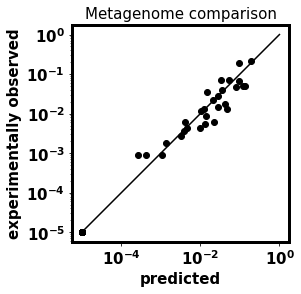

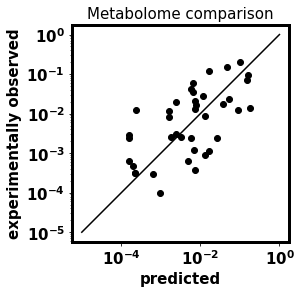

In [41]:
netNUM = 88
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added, net_added_full])

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
#print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))


In [45]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
#netNUM = 0
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added, net_added_full])

corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
log_list = np.zeros((41,2))
for pa in range(41):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
#'''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:')
print(np.mean(corr_list[:,1]))
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))
#'''
#corr_allreplicates.append(np.mean(corr_list[:,1]))
#log10_allreplicates.append(np.mean(log_list[:,1]))


/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:
0.751173258504072
Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:
0.5072523400080913


In [46]:
len(net_new) - len(net_ori)

331

In [48]:
netNUM = 88
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net_ori.columns
net_new = pd.concat([net_ori, net_added])

NUMADDED = len(net_new) - len(net_ori)

df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_errorReduced = df[netNUM]['error reduced'].values
df_added_errorReduced = pd.DataFrame(df_added_errorReduced)
df_added_errorReduced.index = range(NUMADDED)
df_added_errorReduced.columns = ['error reduced'] 

df_added_step = df[netNUM]['step added'].values
df_added_step = pd.DataFrame(df_added_step)
df_added_step.index = range(NUMADDED)
df_added_step.columns = ['step added'] 

df_added_pos = df[netNUM]['position in x'].values
df_added_pos = pd.DataFrame(df_added_pos)
df_added_pos.index = range(NUMADDED)
df_added_pos.columns = ['position in x'] 

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes,  df_added_errorReduced, df_added_step, df_added_pos], axis=1, sort=False)
df_added_tables.sort_values(by = 'error reduced', ascending=False)


,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
25,2122,Isovalerate (3-Methylbutanoic acid),123,Bacteroides dorei,3,0.037072,122,23625
15,2238,Urea,464,Faecalibacterium prausnitzii,3,0.026613,87,31436
1,2125,"L-Alanine (D-Alanine, Alanine)",159,Bilophila wadsworthia,3,0.019156,9,23785
11,2133,"L-Glutamate (L-Glutamic acid, Glutamate, D-Glu...",159,Bilophila wadsworthia,3,0.016930,64,24361
3,2238,Urea,124,Bacteroides eggerthii,3,0.012380,18,31402
44,2201,Propanoate (Propionate),338,Coprococcus comes,2,0.011600,308,12993
6,2133,"L-Glutamate (L-Glutamic acid, Glutamate, D-Glu...",126,Bacteroides fragilis,3,0.011394,41,24348
70,2201,Propanoate (Propionate),161,Blautia hansenii (Ruminococcus hansenii),3,0.010708,850,28898
23,2240,"Valerate (Pentanoic acid, Pentanoate)",329,Collinsella aerofaciens (Eubacterium aerofaciens),3,0.009174,107,31568
54,2217,Succinate,953,Roseburia inulinivorans,2,0.007873,450,14100


3230 30787
0.1049144119271121
76
40
P-value is 7.11680714360341e-11


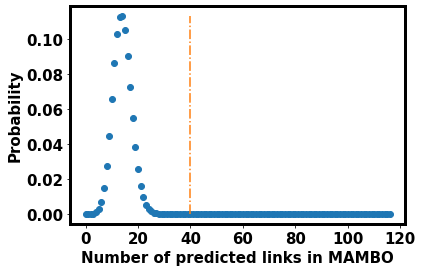

In [51]:
max_links = MAX_ID_metabolites * MAX_ID_microbes
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("../mambo_curated.txt", sep = '\t')
df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))

print((len(df_MAMBO_filtered)-numOverlap), (2*max_links - len(net_ori)))
print((len(df_MAMBO_filtered)-numOverlap) / (2*max_links - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / (2*max_links)
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))


In [47]:
df_all.sort_values(['metabolite ID', 'microbes ID'])

#pd.unique(df_all)
df_all[['metabolite ID', 'microbes ID', 'edgeType', 'position in x']].drop_duplicates()

,metabolite ID,microbes ID,edgeType,position in x
0,2212,457,2,13793
1,2217,124,2,14050
2,2081,309,2,5212
3,2238,457,3,31433
4,2081,131,2,5198
5,2233,513,2,15167
6,2240,969,2,15689
7,2106,9,3,22680
8,2238,870,3,31447
9,2240,124,3,31546


In [100]:
pos_sig = list(prevOfLinksSorted.keys())[:numOfSigLinks]
#list(prevOfLinksSorted.values())[:numOfSigLinks]
pos_sig

[18458,
 28911,
 25433,
 27017,
 28898,
 31601,
 23685,
 24909,
 23785,
 24345,
 28897,
 16648,
 24405,
 31545,
 31590,
 24361,
 20101,
 24375,
 23920,
 24089,
 24521,
 20122,
 24087,
 31380,
 28240,
 23655,
 25053,
 31595,
 25145,
 24353,
 25693,
 23675,
 27754,
 23677,
 23799,
 24380,
 31605,
 27012,
 18013,
 30828,
 19091,
 23820,
 24092,
 24492,
 23657,
 23772,
 18501,
 25864,
 24497,
 24996,
 25081,
 31480,
 24346,
 26033,
 28241,
 25788,
 19609,
 23676,
 30829,
 31482,
 25082,
 16653,
 15153,
 20373,
 18467,
 25882,
 23999,
 24565,
 31551,
 27501,
 25097,
 25168,
 24667,
 31569,
 5729,
 16550,
 6879,
 24568,
 26344,
 31575,
 24109,
 18457,
 16645,
 27493,
 16579,
 24397,
 31621,
 31542,
 22651,
 5982,
 24524,
 24396,
 24386,
 17318,
 24635,
 25886,
 25138,
 23786,
 24541,
 24351,
 28766,
 23654,
 16506,
 29656,
 23622,
 19083,
 23200,
 25861,
 30756,
 23642,
 31333,
 31553,
 26291,
 31561,
 15194,
 26180,
 23625,
 16581,
 25287,
 24362,
 5244,
 23218,
 25981,
 2534,
 18038,
 2523

In [101]:
df_all = df[0].copy()
for i in range(1, 100):
    df_all = pd.concat([df_all, df[i]])
df_all.set_index('position in x', inplace=True)
df_all.loc[pos_sig]

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added
position in x,,,,,,,
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000193,2191
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.003172,575
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.001280,3227
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000765,2593
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.004593,1670
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.003017,823
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000970,3070
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.002122,818
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,-0.000208,5529


In [110]:
ys_actual, xs_actual = np.histogram(list(prevOfLinksSorted.values()), bins=5, normed=True)
print(xs_actual, ys_actual)

[ 1.   4.6  8.2 11.8 15.4 19. ] [0.24300303 0.02742057 0.00556816 0.00136578 0.00042024]


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [139]:
numOfSigLinks = np.sum(np.array(list(prevOfLinksSorted.values())) >= threshold)
numOfTotalLinks = np.array(list(prevOfLinksSorted.values())).shape[0]
print(numOfSigLinks, numOfTotalLinks)
print(numOfSigLinks / numOfTotalLinks)

511 2644
0.193267776096823


In [ ]:



df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))